In [8]:
import json
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import matplotlib.pyplot as plt
from interaction_inference import simulation
from interaction_inference.constraints import Constraint
from interaction_inference.optimization import Optimization

In [31]:
rng = np.random.default_rng(3)

# Downsamled optimization: Independent models

Due to binomial downsampling with the same capture efficiencies for each gene, the downsampled counts are positively correlated. So even if the original counts are sampled from a model with independent genes, the downsampled counts are not independent.

This means that for an independent model e.g. independent birth-death, we cannot use the 'marginal downsampled CME' as this would be assuming the downsampled counts are also independent (but are in fact positively correlated) and must use the 'joint downsampled CME' with the joint downsampled distribution (i.e. interacting birth-death model constraints with $k_{reg} = 0$):

$$
\begin{align}
0 =& k_{tx_1} p_{D} (x_1 - 1, x_2) \\
+& k_{tx_2} p_{D} (x_1, x_2 - 1) \\
+& k_{deg_1} (x_1 + 1) p_{D} (x_1 + 1, x_2) \\
+& k_{deg_2} (x_2 + 1) p_{D} (x_1, x_2 + 1) \\
-& (k_{tx_1} + k_{tx_2} + k_{deg_1} x_1 + k_{deg_2} x_2) p_{D} (x_1, x_2)
\end{align}
$$

Had mistakenly used 'marginal downsampled CME' in optimization test, so now investigate changes when fixing.


## Plan

- simulate independent & interacting birth-death data to check new downsampled 'independent' model constraints work
- vary interaction strength and capture efficiency (gridtest?) to measure performance, compare to performance of old (wrong) constraints
- investigate difference between new and old constraints (exteme cases?)
- test X1X2X3, X1X2X3X4 cases to see if detecting interaction between specific genes, or just in general

In [27]:
# simulate sample
data = simulation.simulate_dataset_range_BD(
    name = "test",
    interaction_values = [5, 4.5, 4, 3.5, 3, 2.5, 2, 1.5, 1, 0.5, 0],
    cells = 1000,
    rate = 1,
    tqdm_disable = False
)

100%|██████████| 11/11 [00:07<00:00,  1.40it/s]


In [28]:
# bootstrap
data.compute_moments(tqdm_disable=False)
data.compute_probabilities(display=False, tqdm_disable=False)
data.compute_fm(tqdm_disable=False)

100%|██████████| 11/11 [00:00<00:00, 23.89it/s]


In [29]:
# construct constraints
constraints = Constraint(
    downsampled_probability = True,
    downsampled_CME         = True,
    k_deg_1                 = True,
    k_reg                   = True
)

# optimize
opt = Optimization(data, constraints, tqdm_disable=True)

Optimization status: INFEASIBLE
Runtime: 0.015000104904174805
Optimization status: INFEASIBLE
Runtime: 0.14299988746643066
Optimization status: INFEASIBLE
Runtime: 0.012000083923339844
Optimization status: INFEASIBLE
Runtime: 0.03900003433227539
Optimization status: INFEASIBLE
Runtime: 0.051999807357788086
Optimization status: INFEASIBLE
Runtime: 0.04800009727478027
Optimization status: INFEASIBLE
Runtime: 0.009999990463256836
Optimization status: OPTIMAL
Runtime: 0.006000041961669922
Optimization status: OPTIMAL
Runtime: 0.016000032424926758
Optimization status: OPTIMAL
Runtime: 0.0070002079010009766
Optimization status: OPTIMAL
Runtime: 0.0


In [30]:
# construct old constraints
constraints = Constraint(
    downsampled_marginal_probability_1 = True,
    downsampled_marginal_probability_2 = True,
    downsampled_marginal_CME_1         = True,
    downsampled_marginal_CME_2         = True,
    k_deg_2                            = True,
    k_deg_1                            = True
)

# optimize
opt = Optimization(data, constraints, tqdm_disable=True)

Optimization status: INFEASIBLE
Runtime: 0.0019998550415039062
Optimization status: INFEASIBLE
Runtime: 0.0009999275207519531
Optimization status: INFEASIBLE
Runtime: 0.0
Optimization status: INFEASIBLE
Runtime: 0.0
Optimization status: INFEASIBLE
Runtime: 0.0009999275207519531
Optimization status: OPTIMAL
Runtime: 0.0
Optimization status: OPTIMAL
Runtime: 0.0019998550415039062
Optimization status: INFEASIBLE
Runtime: 0.0
Optimization status: OPTIMAL
Runtime: 0.0
Optimization status: OPTIMAL
Runtime: 0.0
Optimization status: OPTIMAL
Runtime: 0.003999948501586914


In [60]:
def gridtest(mean_capture_values, interaction_values, runs, rate, cells=1000):

    # result arrays
    result_array_new = np.zeros((len(mean_capture_values), len(interaction_values)))
    result_array_old = np.zeros((len(mean_capture_values), len(interaction_values)))

    # simulate sample
    data = simulation.simulate_dataset_range_BD(
        name = "gridtest",
        interaction_values = interaction_values * runs,
        cells = cells,
        rate = rate,
        tqdm_disable = False
    )

    # for each capture
    for i, m in enumerate(mean_capture_values):

        print(f"{i + 1} / {len(mean_capture_values)}")

        # beta parameter
        b = (1 / m) - 1

        # capture vector
        if b == 0:
            beta = np.ones(cells)
        else:
            beta = rng.beta(1, b, size=cells)

        # downsample
        data_downsamped = data.downsample("gridtest_downsampled", beta)

        # bootstrap
        data_downsamped.bootstrap_probabilities(tqdm_disable=True)
        data_downsamped.compute_fm(tqdm_disable=True)

        # new constraints
        new_constraints = Constraint(
            downsampled_probability = True,
            downsampled_CME         = True,
            k_deg_1                 = True,
            k_reg                   = True
        )
        
        # old constraints
        old_constraints = Constraint(
            downsampled_marginal_probability_1 = True,
            downsampled_marginal_probability_2 = True,
            downsampled_marginal_CME_1         = True,
            downsampled_marginal_CME_2         = True,
            k_deg_2                            = True,
            k_deg_1                            = True
        )

        # optimize
        opt_new = Optimization(data_downsamped, new_constraints, tqdm_disable=True, print_solution=False)
        opt_old = Optimization(data_downsamped, old_constraints, tqdm_disable=True, print_solution=False)

        # store results
        for j, solution in opt_new.result_dict.items():
            if solution['status'] == "INFEASIBLE":
                result_array_new[i, j % runs] += 1 / runs

        for j, solution in opt_old.result_dict.items():
            if solution['status'] == "INFEASIBLE":
                result_array_old[i, j % runs] += 1 / runs

    return result_array_new, result_array_old

In [61]:
def plot_gridtest(result_array_new, result_array_old, mean_capture_values, interaction_values):

    fig, axs = plt.subplots(1, 2, figsize=(10, 6))

    #plt.tight_layout()

    from  matplotlib.colors import LinearSegmentedColormap
    cmap=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256) 

    vmin, vmax = 0, 1

    # new
    img_new = axs[0].imshow(result_array_new, cmap=cmap, vmin=vmin, vmax=vmax)
    axs[0].set_xlabel("Interaction strength")
    axs[0].set_xticks(range(len(interaction_values)))
    axs[0].set_xticklabels(interaction_values)
    axs[0].set_ylabel("Mean capture efficiency (beta distributed)")
    axs[0].set_yticks(range(len(mean_capture_values)))
    axs[0].set_yticklabels(mean_capture_values)
    axs[0].set_title("Downsampled (fixed)")

    # old
    img_old = axs[1].imshow(result_array_old, cmap=cmap, vmin=vmin, vmax=vmax)
    axs[1].set_xlabel("Interaction strength")
    axs[1].set_xticks(range(len(interaction_values)))
    axs[1].set_xticklabels(interaction_values)
    axs[1].set_ylabel("Mean capture efficiency (beta distributed)")
    axs[1].set_yticks(range(len(mean_capture_values)))
    axs[1].set_yticklabels(mean_capture_values)
    axs[1].set_title("Downsampled (wrong)")

    fig.suptitle("Downsampled Birth-death model infeasibility % across range of parameters")

    cbar = plt.colorbar(img_new, ax=axs)
    cbar.set_label("Infeasibility %")

In [62]:
# gridtest ranges
mean_capture_values = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
interaction_values = [50, 20, 10, 8, 6, 4, 2, 1, 0.5, 0]
runs = 3

# parameters
rate = 5
cells = 1000

# gridtest
result_array_new, result_array_old = gridtest(mean_capture_values, interaction_values, runs, rate)

100%|██████████| 30/30 [02:44<00:00,  5.48s/it]


1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10


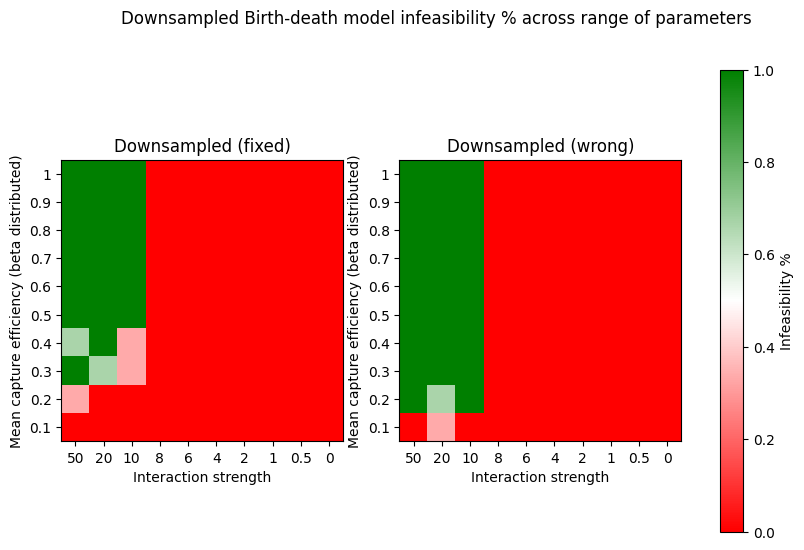

In [63]:
# plot
plot_gridtest(result_array_new, result_array_old, mean_capture_values, interaction_values)

In [64]:
# gridtest ranges
mean_capture_values = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
interaction_values = [50, 20, 10, 8, 6, 4, 2, 1, 0.5, 0]
runs = 3

# parameters
rate = 1
cells = 1000

# gridtest
result_array_new, result_array_old = gridtest(mean_capture_values, interaction_values, runs, rate)

100%|██████████| 30/30 [00:44<00:00,  1.49s/it]


1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10


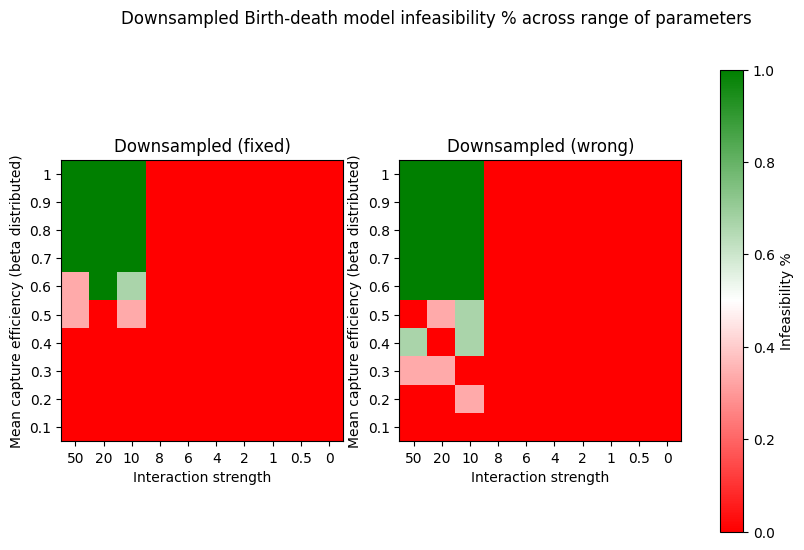

In [65]:
# plot
plot_gridtest(result_array_new, result_array_old, mean_capture_values, interaction_values)

See that old constraints (wrongly using marginal CMEs) are infeasible for lower capture efficieincies than new, but is a small difference